In [71]:
# Import modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import matplotlib.patches as mpatches

In [72]:
# Load the CSV file into a DF
echr_data = "https://docs.google.com/spreadsheets/d/e/2PACX-1vTAFVOx-o3Wo5RZf8EPPEl2SLGRXMoeChCUwnldeFsWoX6H86fGu0pyxVlfT4Mz3E9BqfzW_uwlwO7s/pub?output=csv"
df = pd.read_csv(echr_data)

In [148]:
# Filter the DataFrame to keep only violations
df_cleaned = df[df['violation'].notna() & df['violation'].ne('')]

# List of relevant country codes to keep
prioritized_respondent = ['TUR', 'RUS', 'ITA', 'ROU', 'UKR']

# Function to prioritize certain country codes in multiple entries
def prioritize_countries(codes_str):
    codes_list = [code.strip() for code in codes_str.replace(';', ',').split(',')]
    prioritized_in_entry = [code for code in codes_list if code in prioritized_respondent]
    return prioritized_in_entry[0:1] if prioritized_in_entry else codes_list

# Apply the adjusted function
df['prioritized_respondent'] = df['respondent'].astype(str).apply(prioritize_countries)

# Explode the DataFrame on 'prioritized_respondent' for counting occurrences, adjusted as needed
df_exploded = df.explode('prioritized_respondent')

# Safe split to separate the articles
def safe_split(violation_str):
    if pd.isna(violation_str):
        return []
    else:
        return [item.strip() for item in violation_str.split(';') if item.strip()]

# Apply safe_split directly without intermediate join-split operations
df_exploded['violation'] = df_exploded['violation'].apply(safe_split)

# Explode the 'violation' column now that each entry is a list of violations
df_exploded = df_exploded.explode('violation')

# Reset the index to ensure it's unique after exploding
df_exploded.reset_index(drop=True, inplace=True)

# Explode the 'violation' column to create a new row for each article
df_exploded = df_exploded.explode('violation')

# Strip whitespace from the beginning and end of each 'violation' entry
df_exploded['violation'] = df_exploded['violation'].str.strip()

# Remove rows where the 'violation' column is NaN after splitting and exploding
df_exploded = df_exploded.dropna(subset=['violation'])

# Merge 6 and 6-1 in violation because same article
df_exploded['violation'] = df_exploded['violation'].replace({'6-1': '6'})
df_exploded['violation'] = df_exploded['violation'].replace({'6- 1': '6'})

# Count occurrences
country_counts = df_exploded['prioritized_respondent'].value_counts()

# Select the 5 most recurring countries
top_5_countries = df_exploded['prioritized_respondent'].value_counts().head(5).index

# Select the ranking
top_countries = df_exploded['prioritized_respondent'].value_counts().index

In [149]:
print(top_5_countries)

Index(['RUS', 'TUR', 'UKR', 'ITA', 'ROU'], dtype='object', name='prioritized_respondent')


In [150]:
print(top_countries)

Index(['RUS', 'TUR', 'UKR', 'ITA', 'ROU', 'GRC', 'POL', 'BGR', 'FRA', 'HUN',
       'MDA', 'SVN', 'HRV', 'GBR', 'SVK', 'AZE', 'AUT', 'SRB', 'PRT', 'DEU',
       'BEL', 'CZE', 'MKD', 'LTU', 'ARM', 'LVA', 'FIN', 'BIH', 'ESP', 'ALB',
       'CHE', 'GEO', 'MLT', 'NLD', 'CYP', 'MNE', 'SWE', 'EST', 'LUX', 'IRL',
       'NOR', 'ISL', 'DNK', 'SMR', 'LIE', 'AND', 'MCO'],
      dtype='object', name='prioritized_respondent')


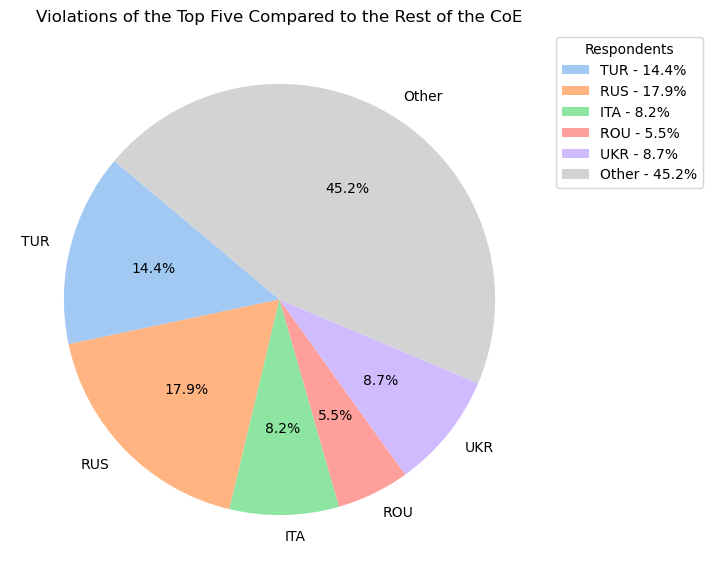

In [151]:
# Occurrences of all respondents
respondent_counts = df_exploded['prioritized_respondent'].value_counts()

# The top 5 prioritized respondents and 'Other'
top_respondents = ['TUR', 'RUS', 'ITA', 'ROU', 'UKR']
top_counts = respondent_counts[top_respondents]
other_count = respondent_counts.sum() - top_counts.sum()

# Labels for the pie chart
labels = top_respondents + ['Other']

# Counts for each segment
counts = top_counts.tolist() + [other_count]

# Colors for the pie chart
colors = sns.color_palette('pastel')[0:len(top_respondents)]
colors.append('lightgrey') 

# Creating the pie chart
plt.figure(figsize=(10, 7))
plt.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Violations of the Top Five Compared to the Rest of the CoE')

# Create a legend with percentages
percentages = [f'{(count / sum(counts)) * 100:.1f}%' for count in counts]
legend_labels = [f'{label} - {percentage}' for label, percentage in zip(labels, percentages)]
plt.legend(legend_labels, title="Respondents", bbox_to_anchor=(1, 1))

plt.show()


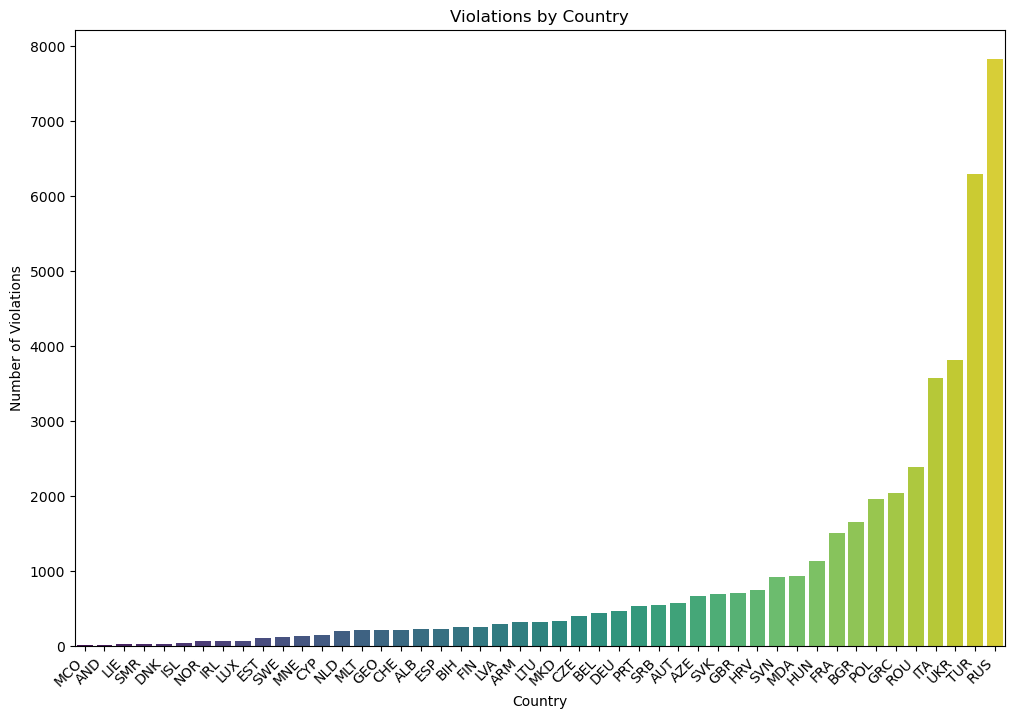

In [152]:
# Count the number of violations by country
violations_by_country = df_exploded['prioritized_respondent'].value_counts().sort_values()

# Creating the bar chart in ascending order
plt.figure(figsize=(12, 8))
sns.barplot(x=violations_by_country.index, y=violations_by_country.values, palette='viridis', order=violations_by_country.index)

plt.xticks(rotation=45, ha='right')
plt.xlabel('Country')
plt.ylabel('Number of Violations')
plt.title('Violations by Country')

plt.show()

In [153]:
# Filter for rows where the prioritized respondent is 'RUS'
rus_violations = df_exploded[df_exploded['prioritized_respondent'] == 'RUS']

# Count the occurrences of each violation and get the top 10
top_10_violations_rus = rus_violations['violation'].value_counts().head(10)

print(top_10_violations_rus)

violation
6         1936
3          915
5          807
13         577
P1-1       363
5-1        351
2          347
5-3        278
5-4        243
P1-1-1     212
Name: count, dtype: int64


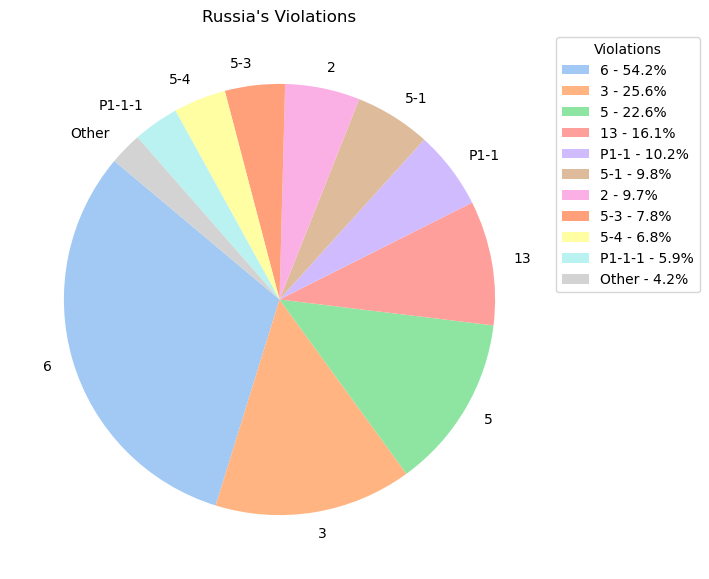

In [175]:
# Calculate the total count of violations for 'RUS'
total_violations_rus_count = rus_violations['violation'].count()

# Calculate the count of 'Other' violations (not in the top 10)
other_violations_rus_count = total_violations_rus_count - top_10_violations_rus.sum()

# Prepare data for the pie chart including 'Other'
labels = top_10_violations_rus.index.tolist() + ['Other']
counts = top_10_violations_rus.tolist() + [other_violations_ita_count]
colors = sns.color_palette('pastel', len(labels) - 1) + ['lightgrey']  # Light grey for 'Other'
if "5-3" in labels:
    p1_index = labels.index("5-3")
    colors[p1_index] = 'lightsalmon'

# Plotting the pie chart
plt.figure(figsize=(10, 7))
plt.pie(counts, labels=labels, colors=colors, startangle=140)
plt.title("Russia's Violations")

# Creating a legend with percentages
percentages = [f'{count / total_violations_ita_count * 100:.1f}%' for count in counts]
legend_labels = [f'{label} - {percentage}' for label, percentage in zip(labels, percentages)]
plt.legend(legend_labels, title="Violations", bbox_to_anchor=(1, 1))

plt.show()

In [177]:
# Filter for rows where the prioritized respondent is 'TUR'
tur_violations = df_exploded[df_exploded['prioritized_respondent'] == 'TUR']

# Count the occurrences of each violation and get the top 10
top_10_violations_tur = tur_violations['violation'].value_counts().head(15)

print(top_10_violations_tur)

violation
6        2590
5         468
3         412
10        372
13        274
2         264
5-3       259
P1-1      180
10-1      177
5-4       168
8         134
2-1       121
11        104
6-3-c      88
5-5        85
Name: count, dtype: int64


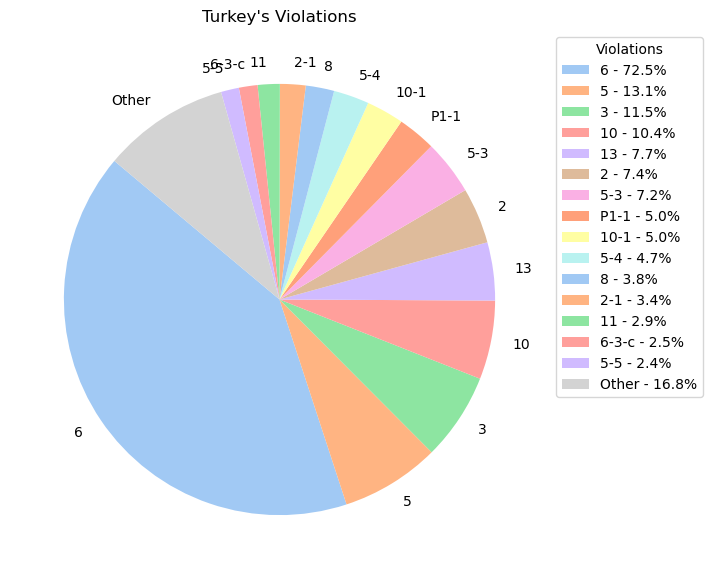

In [178]:
# Calculate the total count of violations for 'TUR'
total_violations_tur_count = tur_violations['violation'].count()

# Calculate the count of 'Other' violations (not in the top 10)
other_violations_tur_count = total_violations_tur_count - top_10_violations_tur.sum()

# Prepare data for the pie chart including 'Other'
labels = top_10_violations_tur.index.tolist() + ['Other']
counts = top_10_violations_tur.tolist() + [other_violations_tur_count]
colors = sns.color_palette('pastel', len(labels) - 1) + ['lightgrey'] 
if "P1-1" in labels:
    p1_index = labels.index("P1-1")
    colors[p1_index] = 'lightsalmon'

# Plotting the pie chart
plt.figure(figsize=(10, 7))
plt.pie(counts, labels=labels, colors=colors, startangle=140)
plt.title("Turkey's Violations")

# Creating a legend with percentages
percentages = [f'{count / total_violations_ita_count * 100:.1f}%' for count in counts]
legend_labels = [f'{label} - {percentage}' for label, percentage in zip(labels, percentages)]
plt.legend(legend_labels, title="Violations", bbox_to_anchor=(1, 1))

plt.show()

In [67]:
# Filter for rows where the prioritized respondent is 'ITA'
ita_violations = df_exploded[df_exploded['prioritized_respondent'] == 'ITA']

# Count the occurrences of each violation and get the top 10
top_10_violations_ita = ita_violations['violation'].value_counts().head(10)

print(top_10_violations_ita)

violation
6         1475
6-1       1396
8          162
13          92
P1-1        90
P1-1-1      69
3           47
8-1         43
5           31
5-1         17
Name: count, dtype: int64


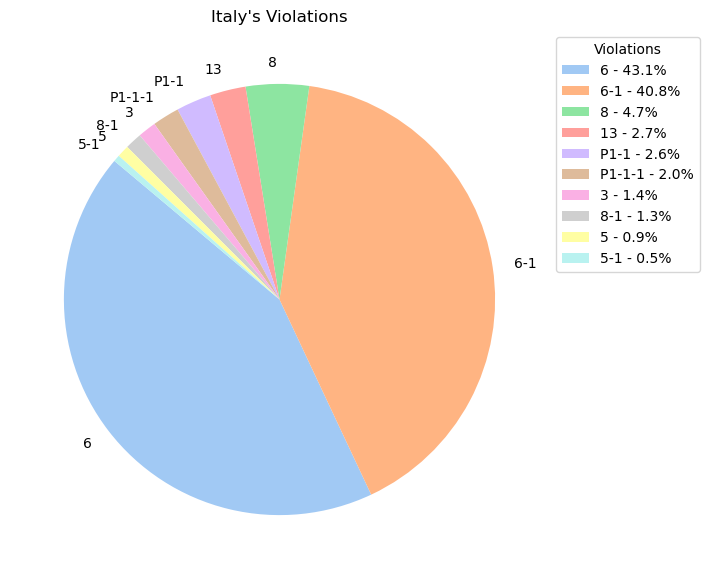

In [166]:
# Data for the pie chart
labels = top_10_violations_ita.index.tolist()
counts = top_10_violations_ita.tolist() 
colors = sns.color_palette('pastel', len(labels))

# Plotting the pie chart
plt.figure(figsize=(10, 7))
plt.pie(counts, labels=labels, colors=colors, startangle=140)
plt.title("Italy's Violations")

# Creating a legend with percentages
percentages = [f'{(count / sum(counts)) * 100:.1f}%' for count in counts]
legend_labels = [f'{label} - {percentage}' for label, percentage in zip(labels, percentages)]
plt.legend(legend_labels, title="Violations", bbox_to_anchor=(1, 1))

plt.show()

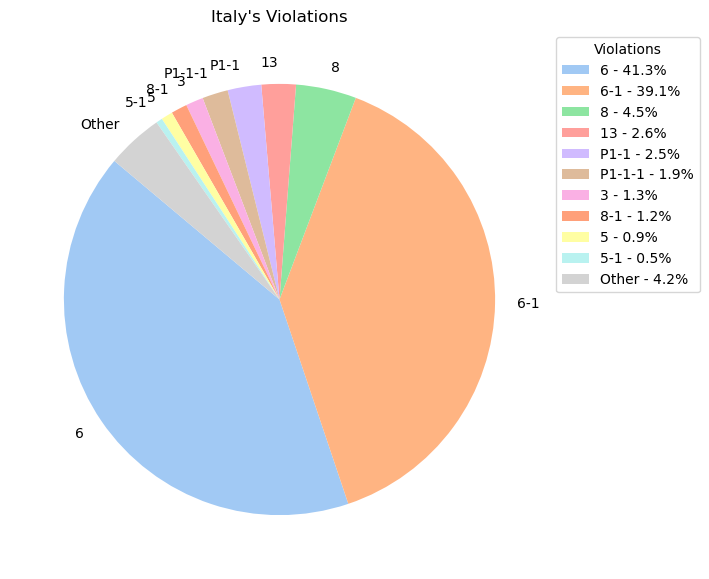

In [173]:
# Calculate the total count of violations for 'ITA'
total_violations_ita_count = ita_violations['violation'].count()

# Calculate the count of 'Other' violations (not in the top 10)
other_violations_ita_count = total_violations_ita_count - top_10_violations_ita.sum()

# Prepare data for the pie chart including 'Other'
labels = top_10_violations_ita.index.tolist() + ['Other']
counts = top_10_violations_ita.tolist() + [other_violations_ita_count]
colors = sns.color_palette('pastel', len(labels) - 1) + ['lightgrey']  # Light grey for 'Other'
if "8-1" in labels:
    p1_index = labels.index("8-1")
    colors[p1_index] = 'lightsalmon'

# Plotting the pie chart
plt.figure(figsize=(10, 7))
plt.pie(counts, labels=labels, colors=colors, startangle=140)
plt.title("Italy's Violations")

# Creating a legend with percentages
percentages = [f'{count / total_violations_ita_count * 100:.1f}%' for count in counts]
legend_labels = [f'{label} - {percentage}' for label, percentage in zip(labels, percentages)]
plt.legend(legend_labels, title="Violations", bbox_to_anchor=(1, 1))

plt.show()

In [69]:
# Filter for rows where the prioritized respondent is 'ROU'
rou_violations = df_exploded[df_exploded['prioritized_respondent'] == 'ROU']

# Count the occurrences of each violation and get the top 10
top_10_violations_rou = rou_violations['violation'].value_counts().head(10)

print(top_10_violations_rou)

violation
6         589
6-1       448
3         339
P1-1      239
8         108
5          79
8-1        64
2          52
P1-1-1     48
14         37
Name: count, dtype: int64


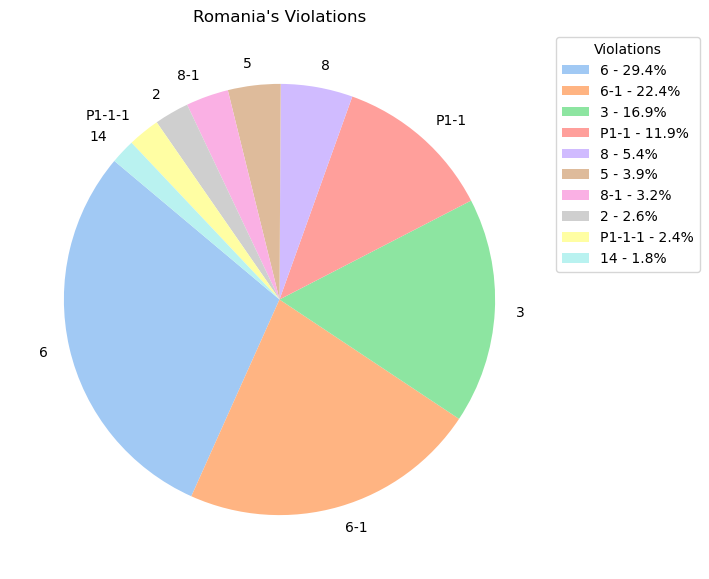

In [167]:
# Data for the pie chart
labels = top_10_violations_rou.index.tolist()
counts = top_10_violations_rou.tolist()
colors = sns.color_palette('pastel', len(labels))

# Plotting the pie chart
plt.figure(figsize=(10, 7))
plt.pie(counts, labels=labels, colors=colors, startangle=140)
plt.title("Romania's Violations")

# Creating a legend with percentages
percentages = [f'{(count / sum(counts)) * 100:.1f}%' for count in counts]
legend_labels = [f'{label} - {percentage}' for label, percentage in zip(labels, percentages)]
plt.legend(legend_labels, title="Violations", bbox_to_anchor=(1, 1))

plt.show()

In [70]:
# Filter for rows where the prioritized respondent is 'ROU'
ukr_violations = df_exploded[df_exploded['prioritized_respondent'] == 'UKR']

# Count the occurrences of each violation and get the top 10
top_10_violations_ukr = rou_violations['violation'].value_counts().head(10)

print(top_10_violations_ukr)

violation
6         589
6-1       448
3         339
P1-1      239
8         108
5          79
8-1        64
2          52
P1-1-1     48
14         37
Name: count, dtype: int64


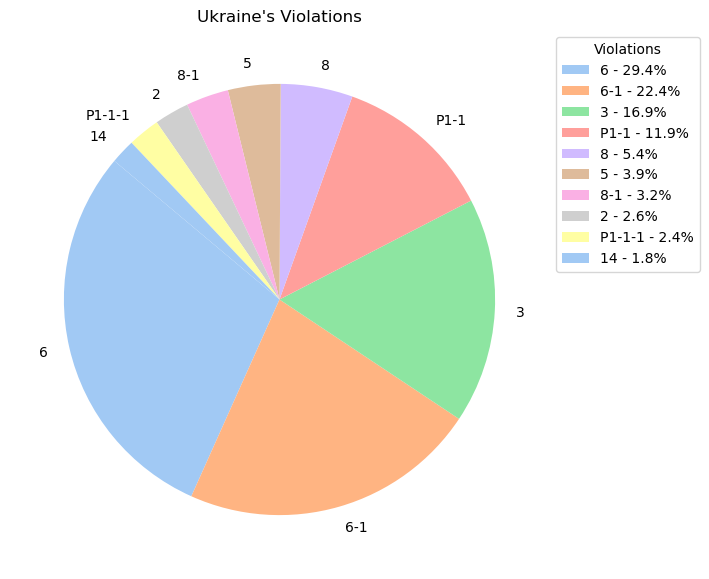

In [114]:
# Data for the pie chart
labels = top_10_violations_ukr.index.tolist()
counts = top_10_violations_ukr.tolist()
colors = sns.color_palette('pastel')[0:len(labels)-1]

# Plotting the pie chart
plt.figure(figsize=(10, 7))
plt.pie(counts, labels=labels, colors=colors, startangle=140)
plt.title("Ukraine's Violations")

# Creating a legend with percentages
percentages = [f'{(count / sum(counts)) * 100:.1f}%' for count in counts]
legend_labels = [f'{label} - {percentage}' for label, percentage in zip(labels, percentages)]
plt.legend(legend_labels, title="Violations", bbox_to_anchor=(1, 1))

plt.show()

In [127]:
# Select the 10 most violated rights
top_rights = df_exploded['violation'].value_counts().head(17)

print(top_rights)

violation
6         20100
3          2792
5          2684
13         2553
P1-1       1709
8          1515
5-3        1149
P1-1-1      989
5-1         974
5-4         908
2           908
10          892
8-1         716
2-1         481
10-1        436
13+3        379
6-3-c       344
Name: count, dtype: int64


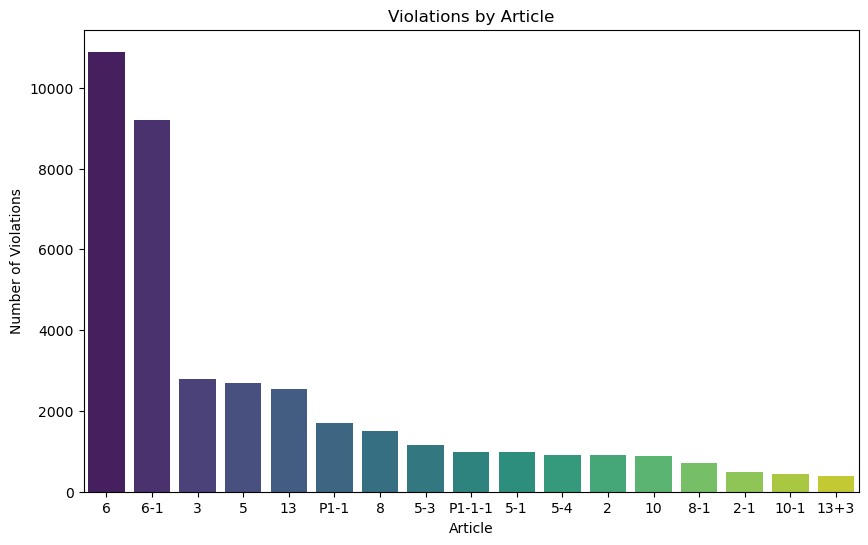

In [126]:
# Sort the counts for better visualization (optional)
article_counts_sorted = top_rights.sort_values(ascending=True)

# Creating the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=article_counts_sorted.index, y=article_counts_sorted.values, palette='viridis', order=top_rights.index)

plt.xlabel('Article')
plt.ylabel('Number of Violations')
plt.title('Violations by Article')

plt.show()
